In [1]:
import astropy.constants as c
import astropy.units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Section 1: Statistics of the Data Cube

## Q1

In [2]:
hdul = fits.open('/Users/simonsmith/Documents/SURP/HC2/HC2_HC5N_all_rebase3_trim.fits')
head = hdul[0].header
data = hdul[0].data

In [3]:
head

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  330                                                  
NAXIS2  =                  524                                                  
NAXIS3  =                  334                                                  
BUNIT   = '' / Tmb                                                              
INSTRUME= 'KFPA    '                                                            
BMAJ    = 0.008458002825349066                                                  
BMIN    = 0.008458002825349066                                                  
BPA     =                  0.0                                                  
TELESCOP= 'GBT     '                                                            
WCSAXES =                   

## Q2

In [4]:
x_pix, y_pix, z_pix = head['NAXIS1'], head['NAXIS2'], head['NAXIS3']
x_deg, y_deg = x_pix*head['CDELT1']*u.deg, y_pix*head['CDELT2']*u.deg

x_pc, y_pc = (x_deg.to(u.rad)*140*u.pc)/u.rad, (y_deg.to(u.rad)*140*u.pc)/u.rad
x_au, y_au = x_pc.to(u.au), y_pc.to(u.au)

d_freq = head['CDELT3']*u.Hz
d_v = (c.c*(d_freq/(head['RESTFRQ']*u.Hz))).to(u.m/u.s)

rad_v = []
freqs = []
for i in range(z_pix):
    freq = head['CRVAL3']*u.Hz - (i-head['CRPIX3'])*d_freq
    freqs.append(freq/u.Hz)
    rad_v.append((c.c*(1 - freq/(head['RESTFRQ']*u.Hz))).to(u.m/u.s)/(u.m/u.s))
    
rad_v = np.asarray(rad_v)
freqs = np.asarray(freqs)

## Q3

In [5]:
std = np.std(data, axis=0)

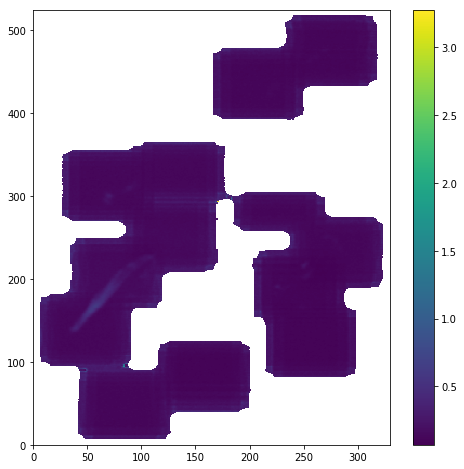

In [6]:
plt.figure(figsize=(8,8))
plt.pcolormesh(std)
plt.colorbar()
plt.show()

## Q4

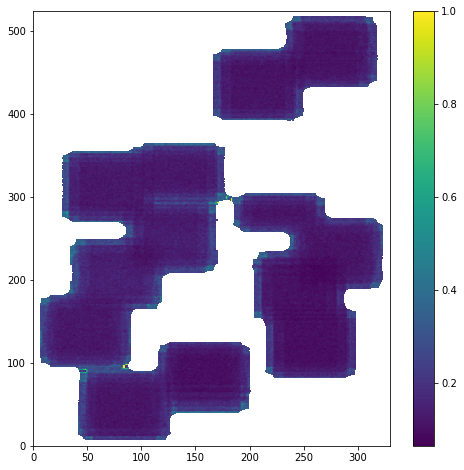

In [8]:
std2 = np.std(data[:100], axis=0)
plt.figure(figsize=(8,8))
plt.pcolormesh(std2, vmax = 1)
plt.colorbar()
plt.show()

In [91]:
spike_starts = np.empty(data[0].shape)
spike_starts[:] = np.NaN

In [95]:
spike_starts.shape[0]

524

In [96]:
spike_starts[0][4]

nan

In [114]:
spike = 0
spec = int_pix(data, 60, 186)
for k in spec:
    if k > 3*np.std(spec):
        spike = np.where(spec == k)[0][0]
    else:
        continue
#spike_starts[i][j] = spike
spike

209

In [8]:
def int_pix(data, x, y):
    return data.T[x][y]

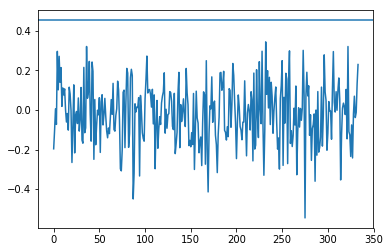

In [82]:
spec = int_pix(data, 51, 45)
plt.plot(spec)
plt.axhline(3*np.std(spec))
#plt.xlim([200, 220])
plt.show()



In [117]:
def spikes(data):
    spike_starts = np.empty(data[0].shape)
    spike_starts[:] = np.NaN

    for i in range(spike_starts.shape[0]):
        for j in range(spike_starts.shape[1]):
            spike = 0
            spec = int_pix(data, j, i)
            print(j, i)
            for k in spec:
                print(k)
                if k > 3*np.std(spec):
                    spike = np.where(spec == k)[0][0]
                elif k == np.NaN:
                    continue
            spike_starts[i][j] = spike

    return spike_starts

In [10]:
spec = int_pix(data, 32, 151)

In [12]:
peak = int(np.where(spec == np.max(spec[5:len(spec)-5]))[0])

if peak == len(spec)-1:
    peak = int(np.where(spec == np.max(spec[:len(spec)-2]))[0])

peaks = sig.peak_widths(spec, [peak])

In [13]:
peaks

(array([2.51161833]),
 array([0.00115921]),
 array([83.50382097]),
 array([86.0154393]))

In [14]:

half_width = int(np.round(peaks[0][0])/2)
left, right = int(np.floor(peaks[2][0]) - half_width), int(np.ceil(peaks[3][0]) + half_width)

In [15]:
new_spec = np.asarray(spec[:left].tolist()+spec[right:].tolist())

In [16]:
np.std(spec), np.std(new_spec)

(0.11590890551295746, 0.11410648166346882)

In [25]:
peak = []
peaks = sig.peak_widths(spec, [peak])
half_width = int(np.round(peaks[0][0])/2)
left, right = int(np.floor(peaks[2][0]) - half_width), int(np.ceil(peaks[3][0]) + half_width)           
new_spec = np.asarray(spec[:left].tolist()+spec[right:].tolist())

IndexError: index 0 is out of bounds for axis 0 with size 0

In [72]:
t = sig.find_peaks(spec)

In [73]:
widths, width_heights, left_ips, right_ips = sig.peak_widths(spec, t[0])

In [74]:
np.where(width_heights == np.max(width_heights))[0][0]

64

In [75]:
int(np.floor(left_ips[64] - widths[64])), int(np.ceil(right_ips[64] + widths[64]))

(205, 208)

In [76]:
new_spec = np.asarray(spec[:205].tolist()+spec[207:].tolist())

In [77]:
np.std(new_spec)

0.31175127376989137

In [78]:
widths[64]

0.6958772902710848

In [ ]:
def extract_onedspec(data, p_start, p_end,
                     n_start, n_end, subtract_chan_mean=True,
                     divide_chan_sigma=True):
    """
    Returns on pulse and off pulse spectrum.
    Parameters:
    data : np.array
    Optimally de-dispersed intensity data
    
    p_start, p_end : int
    Start and stop indices for the on-pulse spectra.
    n_start, n_end : int
    Start and stop indices for the off-pulse spectra (noise). 
    normalize : bool (True)
    Normalize data per channel. Subtract median and divide by standard dev.
    """
   
    
    if subtract_chan_mean:
        data = np.transpose( data.transpose() - np.mean(data.transpose(), axis=0))
    if divide_chan_sigma:
        std = np.std(data, axis=1)
        inv_std = np.zeros_like(std)
        non_zeros = np.where(std>0.005) # prevent it from blowing up.
        inv_std[non_zeros] = 1/std[non_zeros]
        data = np.transpose(data.transpose()*inv_std.transpose())

        
    p_spec = np.mean(data[:,p_start:p_end],axis=1)
    n_spec = np.mean(data[:,n_start:n_end],axis=1)
    spec_std = np.std(data[:,n_start:n_end],axis=1)/np.sqrt(p_end-p_start)
    
    return p_spec, n_spec, spec_std

# Section 2: Moment Maps

In [13]:
def zeroth(data, d_v):
    """
    Calculate zeroth moment for a data set.
    
    Parameters:
    
    data - 3d array
    d_v - float, units: m/s
    
    Returns:
    
    M_0 - 2d array
    """
    
    return np.sum(data, axis=0)*d_v

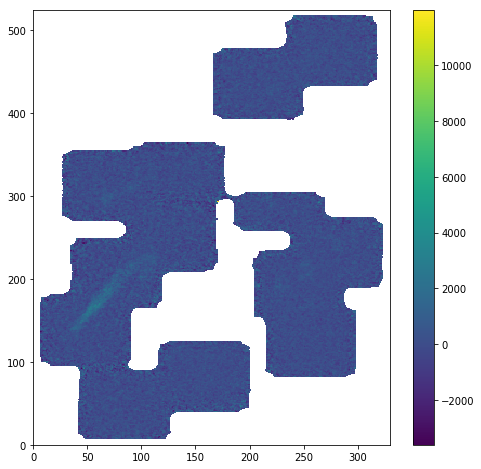

In [14]:
M_0 = zeroth(data, d_v)
plt.figure(figsize=(8,8))
plt.pcolormesh(M_0)
plt.colorbar()
plt.show()

In [15]:
def first(data, rad_v):
    """
    Calculate first moment for a data set.
    
    Parameters:
    
    data - 3d array
    rad_v - 1d array, units: m/s
    
    Returns:

    M_1 - 2d array
    """
    
    return (np.dot(data.T, rad_v)/np.sum(data.T, axis=2)).T

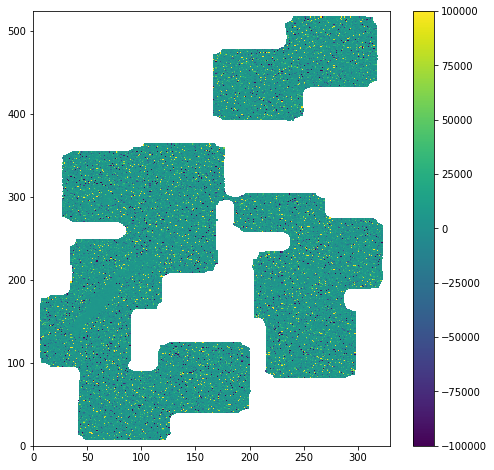

In [22]:
M_1 = first(data, rad_v)
plt.figure(figsize=(8,8))
plt.pcolormesh(M_1, vmax=1e5, vmin=-1e5)
plt.colorbar()
plt.show()

In [26]:
M_1.T[60][180], M_2.T[60][180]

(6051.786867747048, 3600.5133210833587)

In [23]:
def second(data, rad_v, M_1):
    """
    Calculate second moment for a data set.
    
    Parameters:
    
    data - 3d array
    rad_v - 1d array, units: m/s
    M_1 - 2d array
    
    Returns:
    
    M_2 - 2d array
    """
    
    M_2 = np.zeros([data.T.shape[0], data.T.shape[1]])
    for i in range(M_2.shape[0]):
        for j in range(M_2.shape[1]):
            spec = int_pix(data, i, j)
            M_2[i][j] = np.sqrt(np.dot((rad_v-M_1.T[i][j])**2, spec)/np.sum(spec))
    
    return M_2.T

In [20]:
M_2 = second(data, rad_v, M_1)


/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


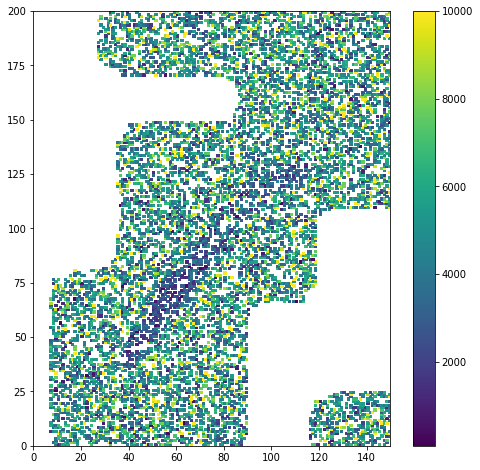

In [36]:
plt.figure(figsize=(8,8))
plt.pcolormesh(M_2[100:300, :150], vmax=1e4)
plt.colorbar()
plt.show()